In [1]:
from epymorph.adrio import acs5
from epymorph import *  # noqa: F403
from epymorph.geography.us_census import StateScope
from epymorph.data.ipm.sirh import Sirh
from epymorph.data.mm.no import No
from epymorph.initializer import Proportional
from epymorph.rume import SingleStrataRume
from epymorph.time import TimeFrame
import numpy as np

duration = 7 * 53 + 1
t = np.arange(0, duration)
true_beta = 0.03 * np.cos(t * 2 * np.pi / (365)) + 0.28
# true_beta = 0 * np.exp(-0.01 * np.maximum(t - 7*10, 0)) + 0.3

rume = SingleStrataRume.build(
    # Load an IPM from the library
    ipm=Sirh(),
    # Load an MM from the library
    mm=No(),
    # Use our scope
    scope=StateScope.in_states(["AZ"], year=2015),
    # Create a SingleLocation initializer
    # Provide an initializer of your coice or create a custom initializer as
    # above and pass it
    init=Proportional(ratios=np.array([9999, 1, 0, 0], dtype=np.int64)),
    # Set the time-frame to simulate
    time_frame=TimeFrame.of("2022-10-01", 7 * 53 + 1),
    # Provide parameter values
    params={
        "beta": true_beta,
        "gamma": 0.25,
        "xi": 1 / 365,  # 0.0111,
        "hospitalization_prob": 0.01,
        "hospitalization_duration": 5.0,
        # Geographic data can be loaded using ADRIOs
        "population": acs5.Population(),
    },
)

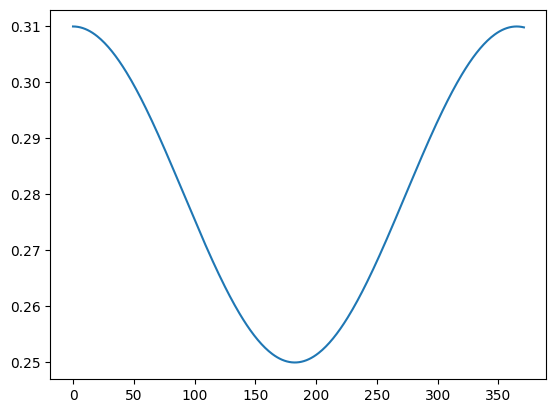

In [2]:
import matplotlib.pyplot as plt


plt.plot(t, true_beta)

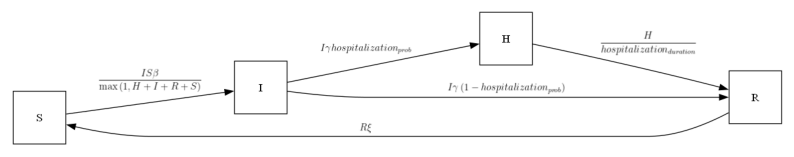

In [3]:
rume.ipm.diagram()

In [4]:
from epymorph.log.messaging import sim_messaging
from epymorph.simulator.basic.basic_simulator import BasicSimulator


sim = BasicSimulator(rume)
with sim_messaging():
    out = sim.run()

Loading gpm:all::init::population (epymorph.adrio.acs5.Population):
  |####################| 100%  (1.513s)
Running simulation (BasicSimulator):
• 2022-10-01 to 2023-10-07 (372 days)
• 1 geo nodes
  |####################| 100%                     
Runtime: 0.045s


In [5]:
from epymorph.time import EveryNDays
from epymorph.tools.data import munge

quantity_selection = rume.ipm.select.events("I->H")
# time_selection = rume.time_frame.select.all()\
#     .group(ByWeek(start_of_week=5)).agg("sum")
time_selection = rume.time_frame.select.all().group(EveryNDays(7)).agg()
geo_selection = rume.scope.select.all()

data_df = munge(
    out,
    quantity=quantity_selection,
    time=time_selection,
    geo=geo_selection,
)

In [6]:
# data_df

In [7]:
data_df.to_csv("./temp_synthetic_data.csv", index=False)

In [8]:
from pathlib import Path
from epymorph.adrio import acs5, csv

csvadrio = csv.CSVTimeSeries(
    file_path=Path("./temp_synthetic_data.csv"),
    time_col=0,
    time_frame=rume.time_frame,
    key_col=1,
    data_col=2,
    data_type=int,
    key_type="geoid",
    skiprows=1,
)

In [9]:
from epymorph.parameter_fitting.filters.particle_filter import ParticleFilter
from epymorph.parameter_fitting.likelihoods.poisson import PoissonLikelihood
from epymorph.parameter_fitting.utils.observations import ModelLink, Observations
from epymorph.parameter_fitting.utils.resampler import ResamplingByNode

observations = Observations(
    source=csvadrio,
    model_link=ModelLink(
        quantity=quantity_selection,
        time=time_selection,
        geo=geo_selection,
    ),
    likelihood=PoissonLikelihood(),
)

filter_type = ParticleFilter(num_particles=1000, resampler=ResamplingByNode)

In [10]:
from epymorph.parameter_fitting.dynamics.dynamics import (
    Calvetti,
    GeometricBrownianMotion,
)
from epymorph.parameter_fitting.utils.parameter_estimation import EstimateParameters
import scipy as sp

params_space = {
    "beta": EstimateParameters.TimeVarying(
        distribution=sp.stats.uniform(loc=0.05, scale=0.5),
        dynamics=GeometricBrownianMotion(volatility=0.04),
    ),
    "xi": EstimateParameters.Static(
        distribution=sp.stats.uniform(loc=1 / 1000, scale=1 / 100),
        dynamics=Calvetti(a=0.9),
    ),
}

In [11]:
from epymorph.parameter_fitting.particlefilter_simulation import FilterSimulation

# print(rume.params)
sim = FilterSimulation(
    rume=rume,
    observations=observations,
    filter_type=filter_type,
    params_space=params_space,
)

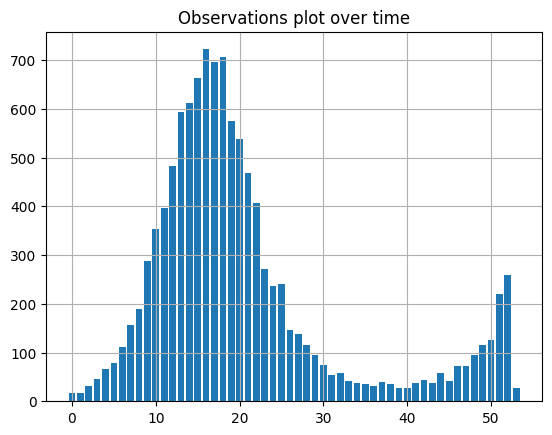

In [12]:
sim.plot_data()

In [13]:
output = sim.run()

Running Particle Filter simulation
• 2022-10-01 00:00:00 to 2023-10-07 00:00:00 (372 days)
• 1000 particles
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53

Simulation completed in 332.53s

Parameters estimated: ['beta', 'xi']


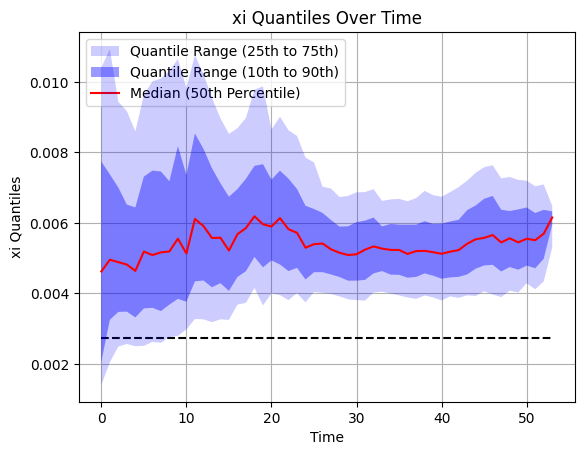

In [14]:
from epymorph.database import NamePattern
from epymorph.parameter_fitting.utils import plots


plots.params_plot(
    output=output,
    key="xi",
    node_index=0,
    truth=rume.params[NamePattern(strata="*", module="*", id="xi")],
)


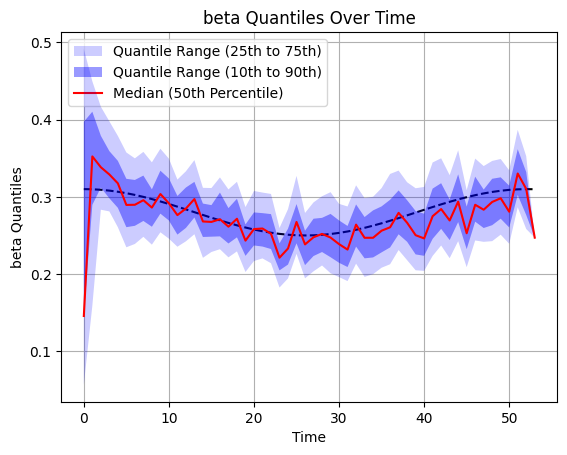

In [15]:
plots.params_plot(
    output=output,
    key="beta",
    node_index=0,
    truth=rume.params[NamePattern(strata="*", module="*", id="beta")][::7],
)


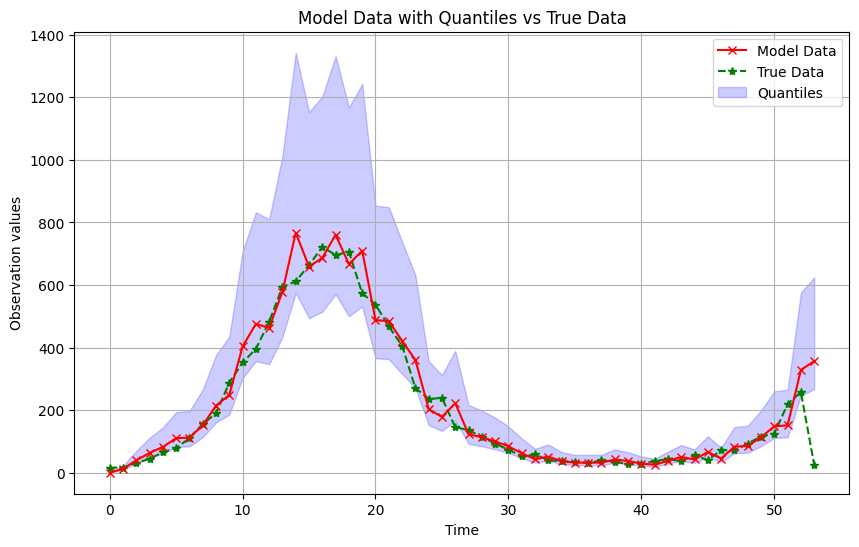

In [16]:
plots.model_fit(output=output, node_index=0)

In [17]:
from pathlib import Path
from epymorph.adrio import acs5, csv

csvadrio = csv.CSVTimeSeries(
    file_path=Path("./influenza.csv"),
    time_col=0,
    time_frame=rume.time_frame,
    key_col=1,
    data_col=2,
    data_type=int,
    key_type="geoid",
    skiprows=1,
)

In [18]:
from epymorph.parameter_fitting.filters.particle_filter import ParticleFilter
from epymorph.parameter_fitting.likelihoods.poisson import PoissonLikelihood
from epymorph.parameter_fitting.utils.observations import ModelLink, Observations
from epymorph.parameter_fitting.utils.resampler import ResamplingByNode

observations = Observations(
    source=csvadrio,
    model_link=ModelLink(
        quantity=quantity_selection,
        time=time_selection,
        geo=geo_selection,
    ),
    likelihood=PoissonLikelihood(),
)

filter_type = ParticleFilter(num_particles=1000, resampler=ResamplingByNode)

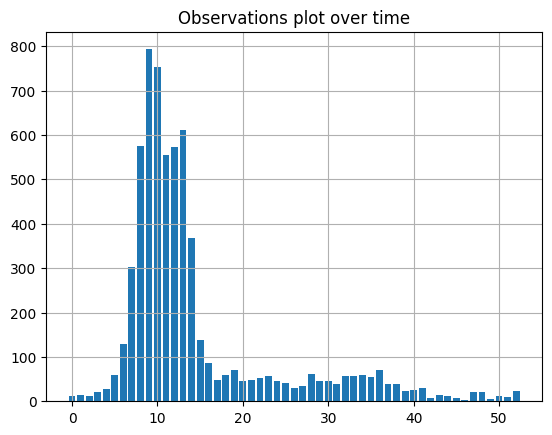

In [19]:
sim = FilterSimulation(
    rume=rume,
    observations=observations,
    filter_type=filter_type,
    params_space=params_space,
)
sim.plot_data()

In [20]:
output = sim.run()

Running Particle Filter simulation
• 2022-10-01 00:00:00 to 2023-09-30 00:00:00 (372 days)
• 1000 particles
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52

Simulation completed in 331.81s

Parameters estimated: ['beta', 'xi']


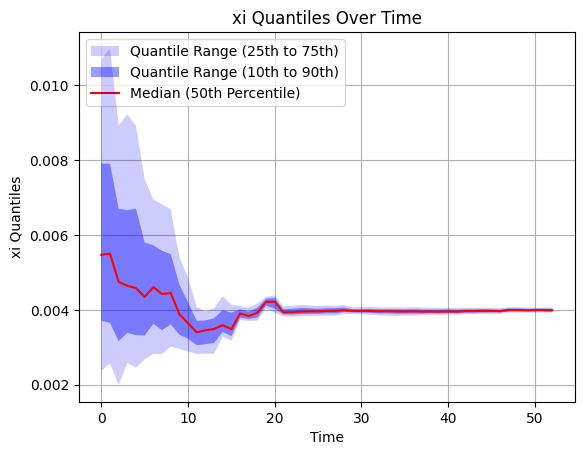

In [21]:
plots.params_plot(
    output=output,
    key="xi",
    node_index=0,
)

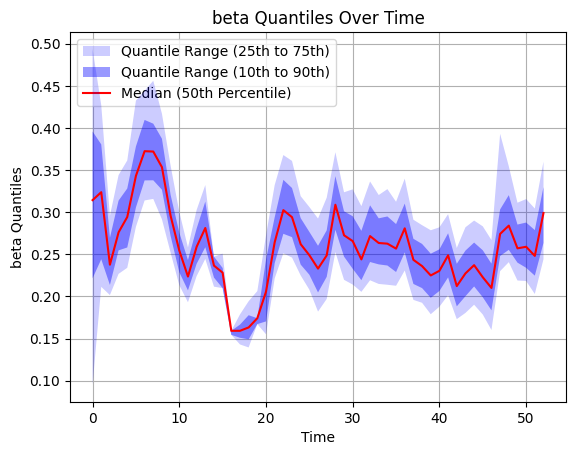

In [22]:
plots.params_plot(
    output=output,
    key="beta",
    node_index=0,
)


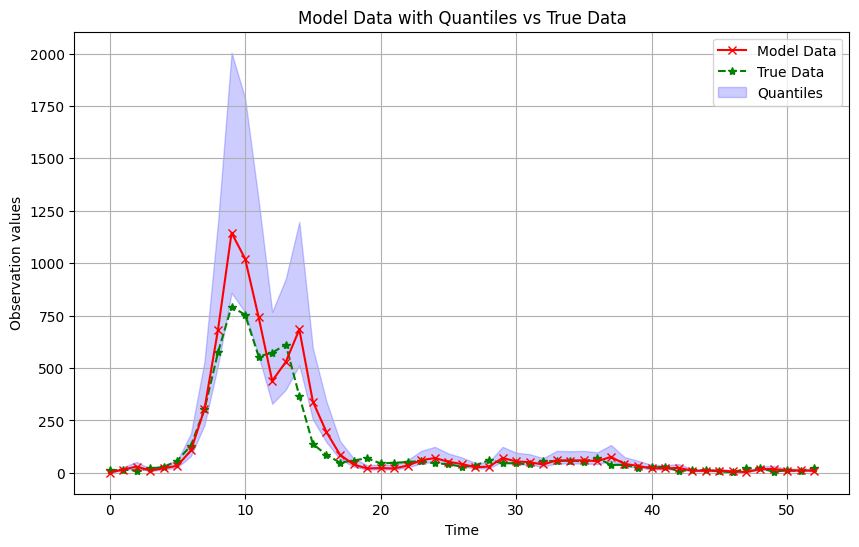

In [23]:
plots.model_fit(output=output, node_index=0)